In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from TreeBasedMethods import DecisionTreeClass, RandomForest, AdaBoost
from optimizer_functions import logistic_regression_sgd
import seaborn as sns
from activation_functions import *
from optimizer_functions import *
from cost_functions import *
from Layer import Layer
from NeuralNetwork import NeuralNetwork
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score as accuracy

In [57]:
# returns list of all metrics given the predicted probability and real class

def classification_metrics(prob_pred,y_test):

    tn, fp, fn, tp = skm.confusion_matrix(y_test, prob_pred.round()).ravel()

    acc = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn+fp)
    fscore = 2*(precision*recall)/(precision+recall)
    auc = skm.roc_auc_score(y_test, prob_pred)

    return [acc, precision, recall, specificity, fscore, auc]

## Data cleaning

In [10]:
# importing Pima Indians Diabetes dataset
df = pd.read_csv('diabetes.csv')

In [11]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [13]:
# Replace inaccurate values with NaN
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

# Fill NaN values with the mean of the respective columns
df['Glucose'] = df['Glucose'].fillna(df['Glucose'].mean())
df['BloodPressure'] = df['BloodPressure'].fillna(df['BloodPressure'].mean())
df['SkinThickness'] = df['SkinThickness'].fillna(df['SkinThickness'].mean())
df['Insulin'] = df['Insulin'].fillna(df['Insulin'].mean())
df['BMI'] = df['BMI'].fillna(df['BMI'].mean())

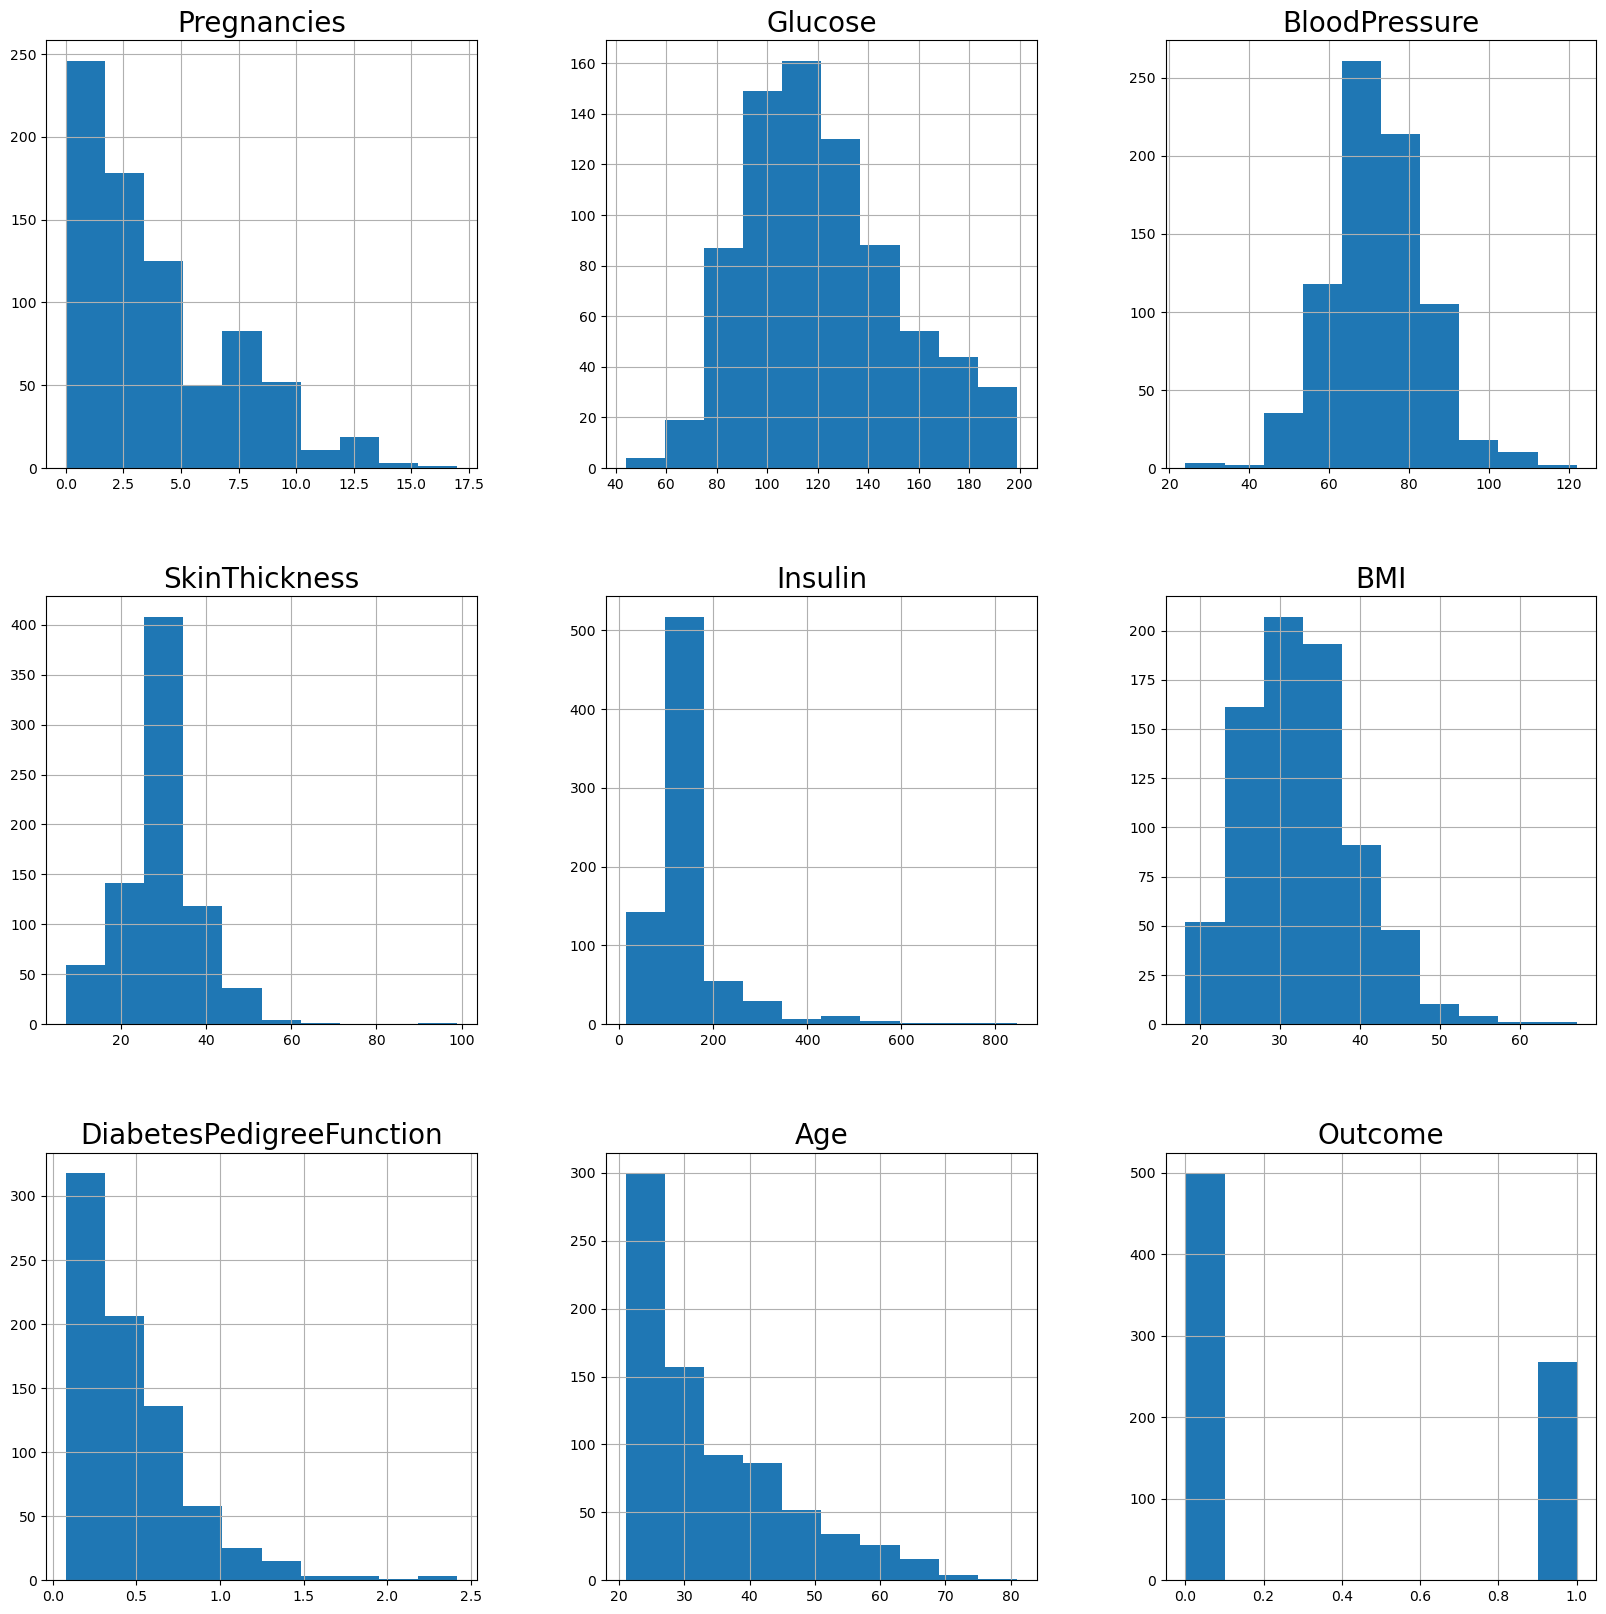

In [14]:
fig = df.hist(figsize=(20, 20))
[x.title.set_size(20) for x in fig.ravel()]
plt.savefig("Variable histogram.png")

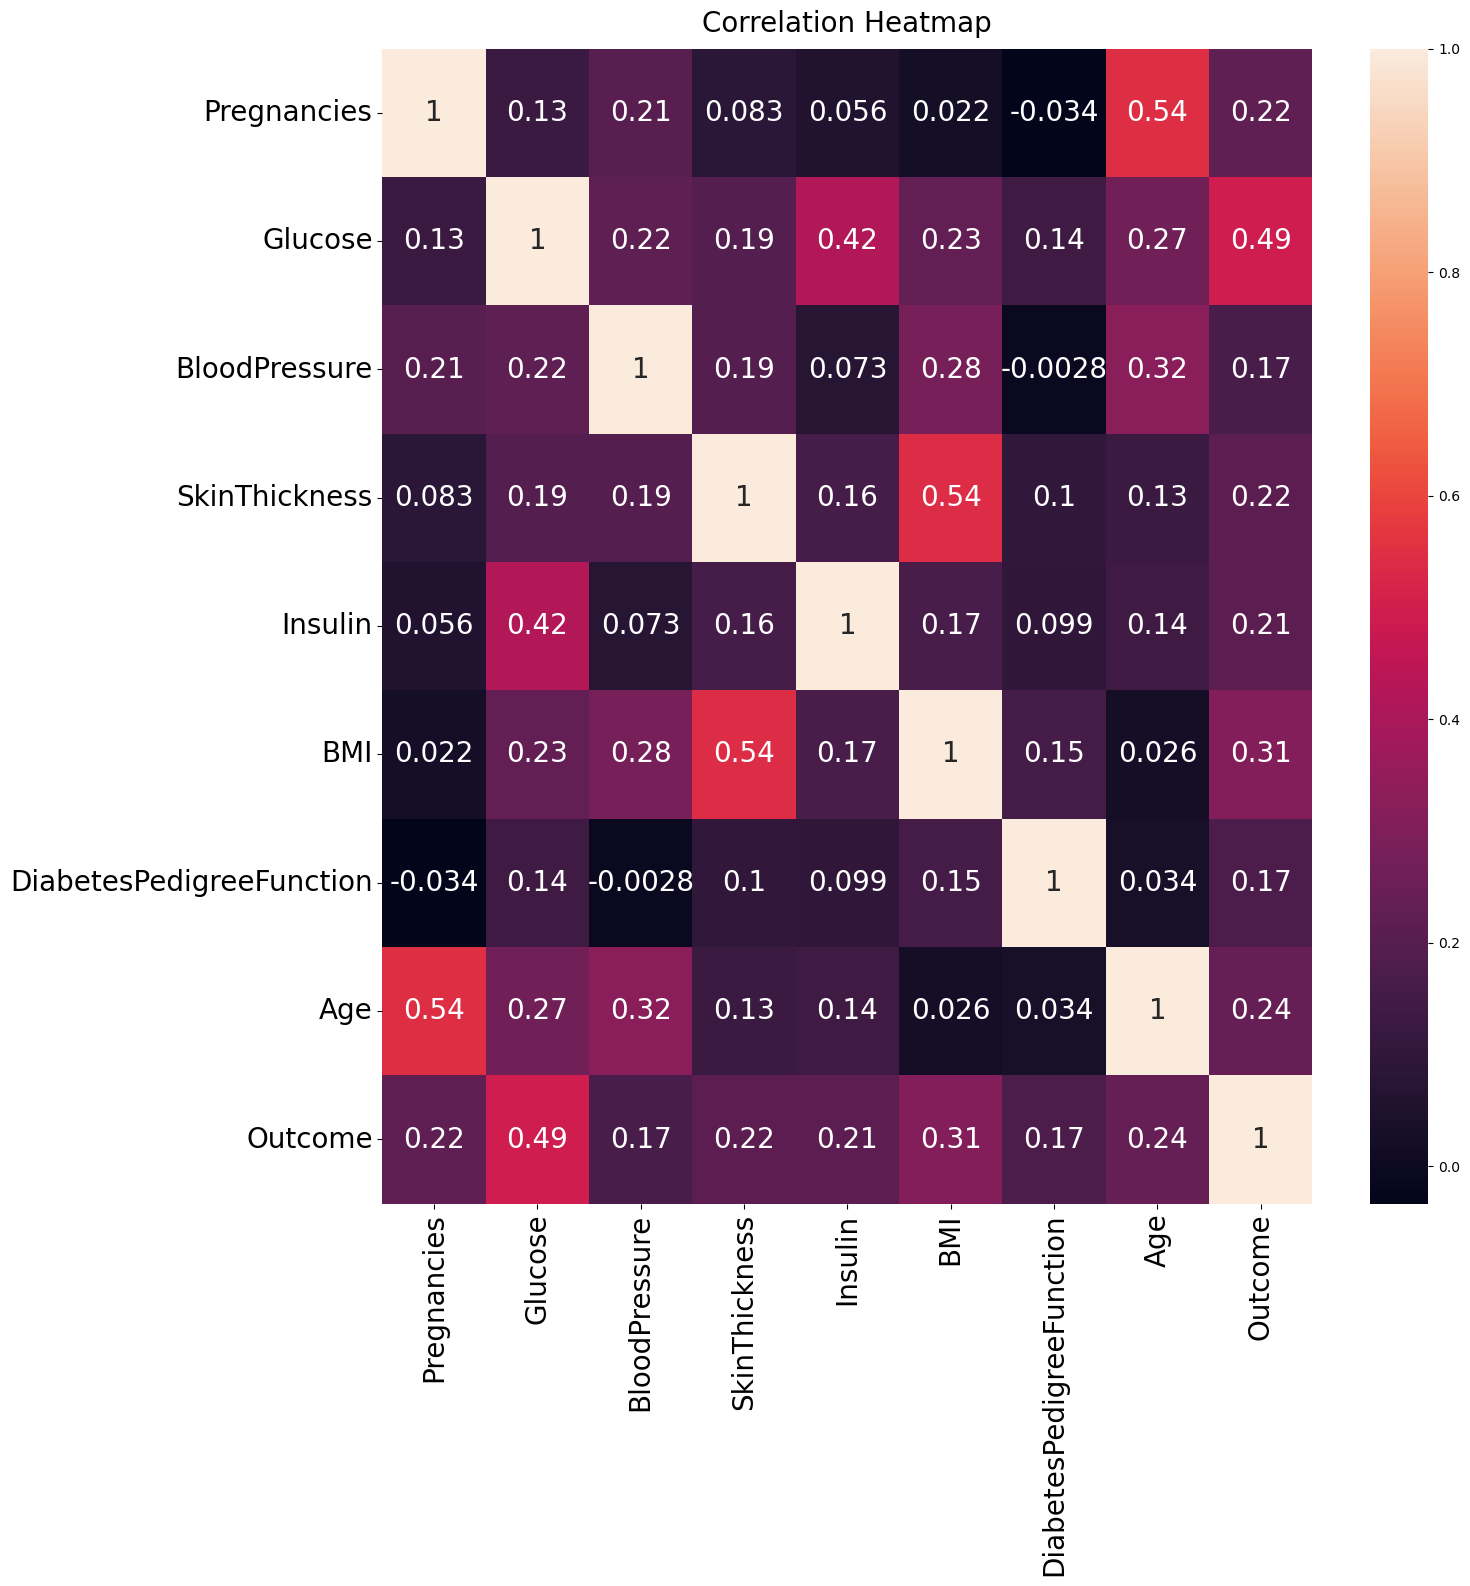

In [32]:
fig = plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df.corr(), annot=True,annot_kws={'fontsize':20})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize=20,rotation=0)
plt.savefig("Correlation heatmap.png")
plt.show()

In [18]:
# splitting in train and test 

X = df.drop('Outcome',axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [19]:
# scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler().fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import collections
import random
import matplotlib.pyplot as plt

def gini_index(y):
    proportions = np.unique(y,return_counts=True)[1]/ len(y)
    gini = np.sum([p * (1-p) for p in proportions if p > 0])
    return gini

def entropy(y):
    proportions = np.unique(y,return_counts=True)[1]/ len(y)
    entropy = -np.sum([p * np.log2(p) for p in proportions if p > 0])
    return entropy

def mse(y):
    return np.sum([(i-np.mean(y))**2 for i in y])

class Node:

    """ Implements a node in a classification tree """ 
    
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):

        # contains feature of split and threshold and references to children nodes if not lead
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        
        # contains predicted value if leaf
        self.value = value
    
    def is_leaf(self):
        # boolean if it's a leaf or not
        return self.value is not None

class DecisionTreeClass:

    """ Implements a classification tree """ 

    def __init__(self, classes=[-1,1], max_depth=100, min_samples_split=2):
        self.classes = classes
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        
    def _is_finished(self, depth):

        # has finished growing the tree if reached max_depth of num_samples in each split

        if (depth >= self.max_depth
            or self.n_class_labels == 1
            or self.n_samples < self.min_samples_split):
            return True
        return False
    
    def _build_tree(self, X, y, depth=0):

        # builds tree recursively by getting the best split

        self.n_samples, self.n_features = X.shape
        self.n_class_labels = len(np.unique(y))

        # stopping criteria
        if self._is_finished(depth):
            if len(np.unique(y)) == 1:
                return Node(value=y[0])
            else:
                most_common_Label = np.argmax(np.unique(y,return_counts=True)[1])
                return Node(value=self.classes[most_common_Label])
        else:
            # get best split
            rnd_feats = np.random.choice(self.n_features, self.n_features, replace=False)
            best_feat, best_thresh = self._best_split(X, y, rnd_feats)

            left_idx, right_idx = self._create_split(X[:, best_feat], best_thresh)
            left_child = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
            right_child = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
            return Node(best_feat, best_thresh, left_child, right_child)
        
    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _create_split(self, X, thresh):

        # splits data given a feature and threshold

        left_idx = np.argwhere(X <= thresh).flatten()
        right_idx = np.argwhere(X > thresh).flatten()
        return left_idx, right_idx

    def _score(self, X, y, thresh, index = gini_index):

        # computes gini index loss (or other score) for a split

        parent_loss = index(y)
        left_idx, right_idx = self._create_split(X, thresh)
        n, n_left, n_right = len(y), len(left_idx), len(right_idx)

        if n_left == 0 or n_right == 0: 
            return 0
        
        child_loss = (n_left / n) * index(y[left_idx]) + (n_right / n) * index(y[right_idx])
        return parent_loss - child_loss

    def _best_split(self, X, y, features):

        # finds the best split by looking at all features and possible thresholds

        split = {'score': -1, 'feat': None, 'thresh': None}

        for feat in features:
            X_feat = X[:, feat]
            thresholds = np.unique(X_feat)
            for thresh in thresholds:
                score = self._score(X_feat, y, thresh)
                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['thresh'] = thresh

        return split['feat'], split['thresh']
    
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

class RandomForest:
    
    """ Implements the Random Forest ensemble method """ 

    def __init__(self, num_trees=25, min_samples_split=2, max_depth=5):

        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

        # list to store the trained decision trees
        self.decision_trees = []
        
    def _sample(self, X, y):

        # function to create bootstrap samples

        n_rows, n_cols = X.shape
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], y[samples]
        
    def fit(self, X, y):

        # trains the classifier

        # reset the trees
        if len(self.decision_trees) > 0:
            self.decision_trees = []
            
        # build each tree of the forest
        num_built = 0
        while num_built < self.num_trees:
            clf = DecisionTreeClass(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth
            )
            # create sample
            _X, _y = self._sample(X, y)
            # Train
            clf.fit(_X, _y)

            self.decision_trees.append(clf)
            num_built += 1
    
    def predict(self, X):
        
        # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))
        
        y = np.swapaxes(a=y, axis1=0, axis2=1)
        
        # Use majority voting for the final prediction
        predictions = []
        for preds in y:
            counter = collections.Counter(preds)
            predictions.append(counter.most_common(1)[0][0])
        return predictions

def compute_error(y, y_pred, w_i):

    # compute weighted misclassification error

    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):

    # compute voting weight for AdaBoost weak classifier

    return np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):

    # update individual weights w_i after a boosting iteration

    weights = w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

    return weights/sum(weights)
    
class AdaBoost:
    
    """ Implements the AdaBoost ensemble method """

    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def fit(self, X, y, M = 100):


        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # iterate over M weak classifiers
        for m in range(0, M):
            
            # set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # initially weights are all equal to 1 / N
            else:
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            #  fit weak classifier and predict labels
            G_m = DecisionTreeClass(max_depth = 1)  

            sample = random.choices(np.arange(len(y)), w_i, k=len(y))

            X_ = X[sample]
            y_ = y[sample]

            G_m.fit(X_,y_)
            y_pred = G_m.predict(X)
            
            self.G_M.append(G_m)

            # compute error and alpha
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)

    def predict(self, X):

        # predict using fitted model
       
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        # predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        # calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred

## Comparing implementation

Our implementation tree: 0.7077922077922078
Sklearn tree: 0.7857142857142857
Our implementation Random forest: 0.9025974025974026
Sklearn Random forest: 0.8831168831168831
Our implementation AdaBoost: 0.8961038961038961


C:\Users\user\anaco\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Sklearn AdaBoost: 0.8571428571428571
Test set accuracy with Gradient Boosting and scaled data: 1.00


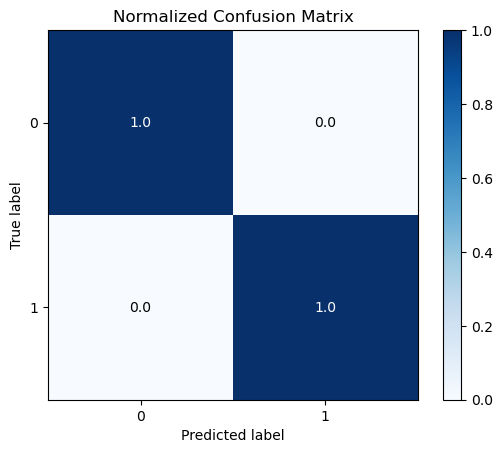

In [31]:
import scikitplot as skplt
import xgboost as xgb




# comparison performance our implementation and sklearn

y_train_comp = np.array(y_train) * 2 - 1
y_test_comp = np.array(y_test) * 2 - 1

clf = DecisionTreeClass(max_depth=200)
clf.fit(X_train, y_train_comp)

y_pred = clf.predict(X_test)
acc = accuracy(y_test_comp, y_pred)

print("Our implementation tree:", acc)

print("Sklearn tree:", DecisionTreeClassifier(max_depth=200).fit(X_train,y_train).score(X_test,y_test))

model = RandomForest(num_trees=200)
model.fit(X_train, y_train_comp)
preds = model.predict(X_test)

acc = accuracy(y_test_comp, preds)

print("Our implementation Random forest:", acc)

print("Sklearn Random forest:", RandomForestClassifier(n_estimators=200).fit(X_train,y_train).score(X_test,y_test))

model = AdaBoost()
model.fit(X_train, y_train_comp, M=200)
preds = model.predict(X_test)

acc = accuracy(y_test_comp, preds)

print("Our implementation AdaBoost:", acc)

print("Sklearn AdaBoost:", AdaBoostClassifier(n_estimators=200).fit(X_train,y_train).score(X_test,y_test))



xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train,y_train)

y_test = xg_clf.predict(X_test)

print("Test set accuracy with Gradient Boosting and scaled data: {:.2f}".format(xg_clf.score(X_test,y_test)))

import scikitplot as skplt
y_pred = xg_clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

plt.savefig("xdclassiffierconfusion.png")
#save_fig("xdclassiffierconfusion")
plt.show()




## Tuning method's parameters and studying performance

### Tree-based methods

In [38]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()

In [39]:
# compute train and test error for different values of cost-complexity parameter

alphas = dec_tree.cost_complexity_pruning_path(X_train,y_train)['ccp_alphas']
len_alphas = len(alphas)

train_err_dec_tree = np.zeros(len_alphas)
test_err_dec_tree = np.zeros(len_alphas)

for i in range(len_alphas):
    a = alphas[i]
    dec_tree.ccp_alpha = a
    dec_tree.fit(X_train,y_train)
    train_err_dec_tree[i] = dec_tree.score(X_train,y_train)
    test_err_dec_tree[i] = dec_tree.score(X_test,y_test)

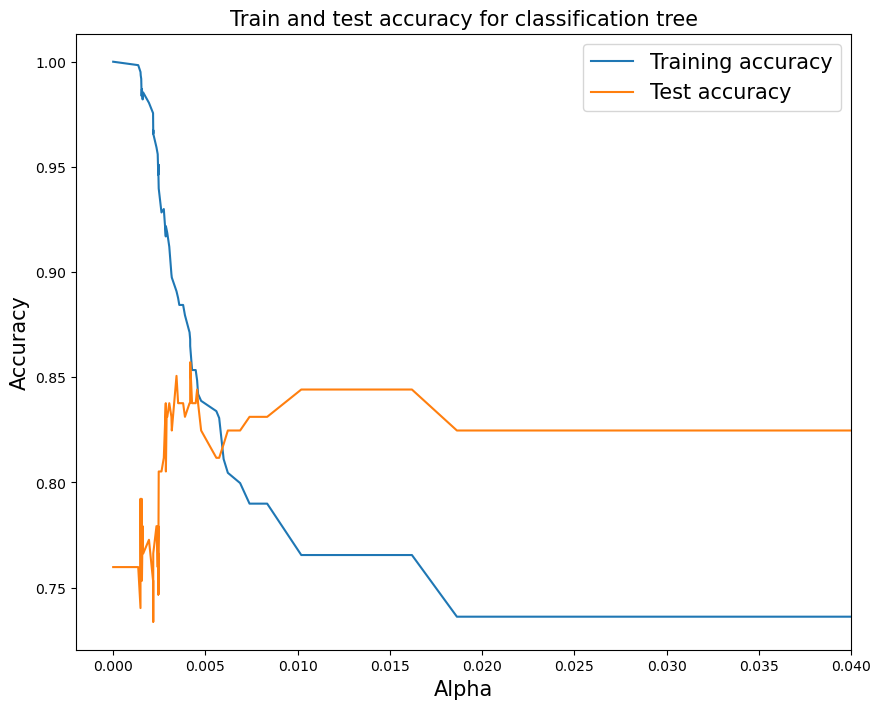

In [42]:
fig = plt.figure(figsize = (10,8))
plt.plot(alphas,train_err_dec_tree, label = 'Training accuracy')
plt.plot(alphas,test_err_dec_tree, label = 'Test accuracy')
plt.legend(fontsize=15)
plt.xlim((-0.002,0.04))
plt.xlabel("Alpha", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Train and test accuracy for classification tree", fontsize=15)
plt.savefig("Train and test accuracy for classification tree.png")
plt.show()


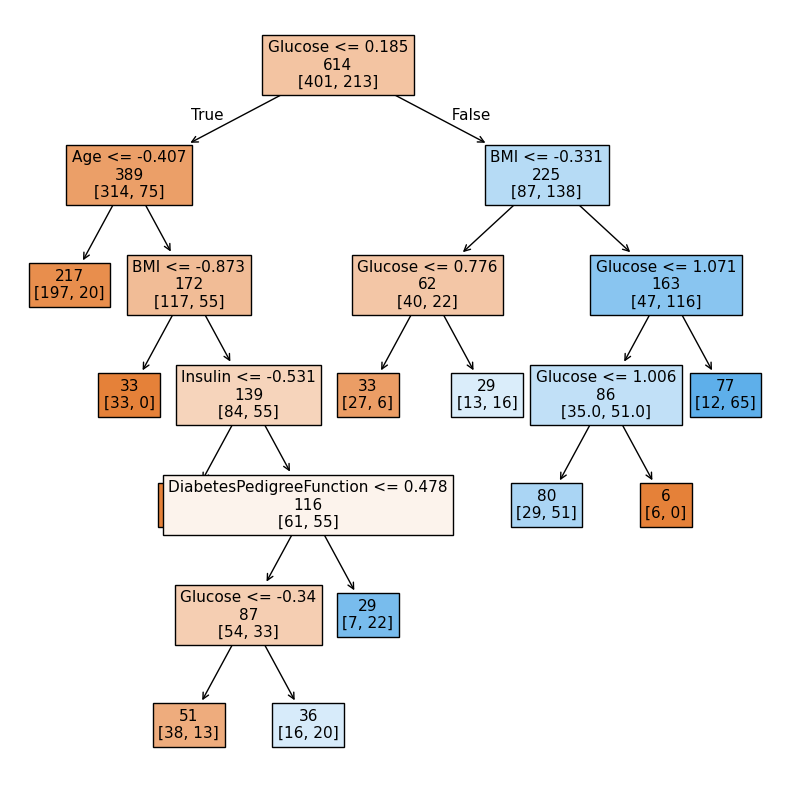

In [43]:
dt = DecisionTreeClassifier(ccp_alpha=0.006).fit(X_train,y_train)
fig = plt.figure(figsize=(10,10))
plot_tree(dt,feature_names=df.columns,impurity=False, label='none', fontsize=11, filled=True)
plt.savefig("Pruned tree.png")
plt.show()

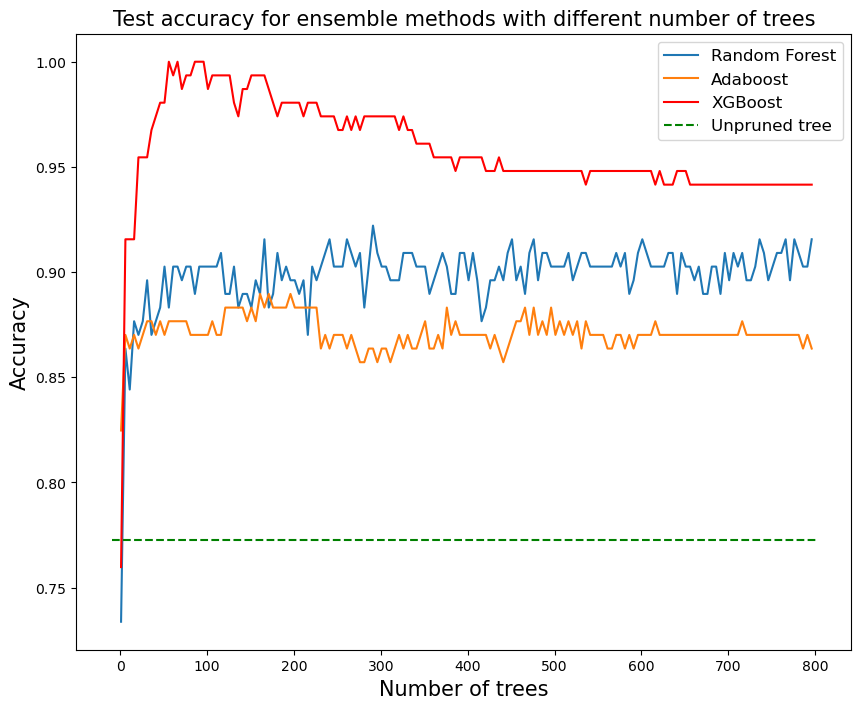

In [45]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np




unpruned_tree_acc = DecisionTreeClassifier().fit(X_train,y_train).score(X_test,y_test)
# Train and compare performance for increasing number of trees
ntrees_v = range(1, 801, 5)

# Initialize models
rf = RandomForestClassifier()
ab = AdaBoostClassifier(algorithm='SAMME')  # Use SAMME instead of SAMME.R
#xg_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Initialize XGBoost
xg_clf = xgb.XGBClassifier(eval_metric='logloss')  # Remove use_label_encoder
xg_clf.fit(X_train, y_train)

# Initialize lists to store error rates
test_err_rf = []
test_err_ab = []
test_err_xg = []

# Iterate over different numbers of trees
for n in ntrees_v:
    # Random Forest
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    test_err_rf.append(rf.score(X_test, y_test))  # Collect test accuracy
    
    # AdaBoost
    ab.n_estimators = n
    ab.fit(X_train, y_train)
    test_err_ab.append(ab.score(X_test, y_test))  # Collect test accuracy
    
    # XGBoost
    xg_clf.n_estimators = n
    xg_clf.fit(X_train, y_train)
    test_err_xg.append(xg_clf.score(X_test, y_test))  # Collect test accuracy

# Plotting the results

fig = plt.figure(figsize = (10,8))
plt.plot(ntrees_v,test_err_rf, label = 'Random Forest')
plt.plot(ntrees_v,test_err_ab, label = 'Adaboost')
plt.plot(ntrees_v, test_err_xg, label='XGBoost', color='red')
plt.hlines(unpruned_tree_acc,-10,801, colors = 'green', label = 'Unpruned tree',linestyles='dashed')
plt.legend(fontsize=12)
plt.xlabel("Number of trees",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.title("Test accuracy for ensemble methods with different number of trees",fontsize=15)

plt.savefig("Test accuracy for ensemble methods with different number of trees.png")
plt.show()



In [48]:
# accuracy rf changing number of predictors at each split

n_vars = range(1,9)

rf = RandomForestClassifier(n_estimators=100)

test_err_rf = []

for n in n_vars:

    rf.max_features = n
    rf.fit(X_train,y_train)
    test_err_rf.append(rf.score(X_test,y_test))

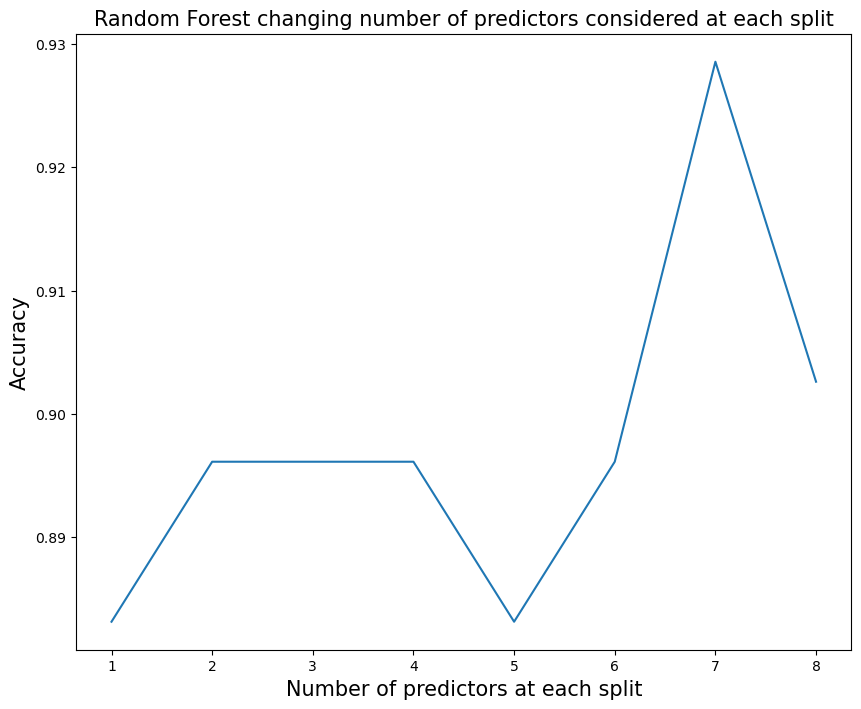

In [49]:
fig = plt.figure(figsize = (10,8))
plt.plot(n_vars,test_err_rf)
plt.xlabel("Number of predictors at each split", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Random Forest changing number of predictors considered at each split", fontsize=15)
plt.savefig("Random Forest changing number of predictors considered at each split.png")
plt.show()


C:\Users\user\anaco\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\user\anaco\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


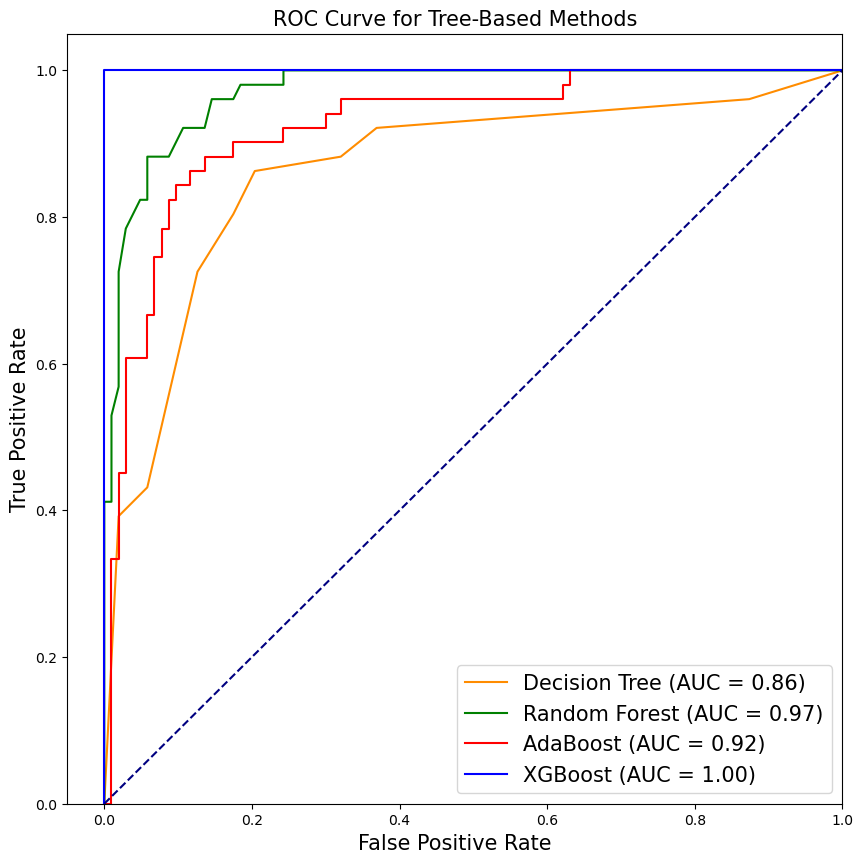

In [50]:
# Decision Tree
dt = DecisionTreeClassifier(ccp_alpha=0.006).fit(X_train, y_train)
dt_probs = dt.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = skm.roc_curve(y_test, dt_probs)
dt_roc_auc = skm.roc_auc_score(y_test, dt_probs)

# Random Forest
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = skm.roc_curve(y_test, rf_probs)
rf_roc_auc = skm.roc_auc_score(y_test, rf_probs)

# AdaBoost
ab = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)
ab_probs = ab.predict_proba(X_test)[:, 1]
ab_fpr, ab_tpr, _ = skm.roc_curve(y_test, ab_probs)
ab_roc_auc = skm.roc_auc_score(y_test, ab_probs)

# XGBoost
xg_clf = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False).fit(X_train, y_train)
xg_probs = xg_clf.predict_proba(X_test)[:, 1]
xg_fpr, xg_tpr, _ = skm.roc_curve(y_test, xg_probs)
xg_roc_auc = skm.roc_auc_score(y_test, xg_probs)

# Plotting the ROC curves
plt.figure(figsize=(10, 10))
plt.plot(dt_fpr, dt_tpr, color="darkorange", label="Decision Tree (AUC = %0.2f)" % dt_roc_auc)
plt.plot(rf_fpr, rf_tpr, color="green", label="Random Forest (AUC = %0.2f)" % rf_roc_auc)
plt.plot(ab_fpr, ab_tpr, color="red", label="AdaBoost (AUC = %0.2f)" % ab_roc_auc)
plt.plot(xg_fpr, xg_tpr, color="blue", label="XGBoost (AUC = %0.2f)" % xg_roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curve for Tree-Based Methods", fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.savefig("ROC_curve_for_tree_based_methods.png")
plt.show()

In [51]:
# variable importance with random forest

rf = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
rf_importances = rf.feature_importances_
rf_std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

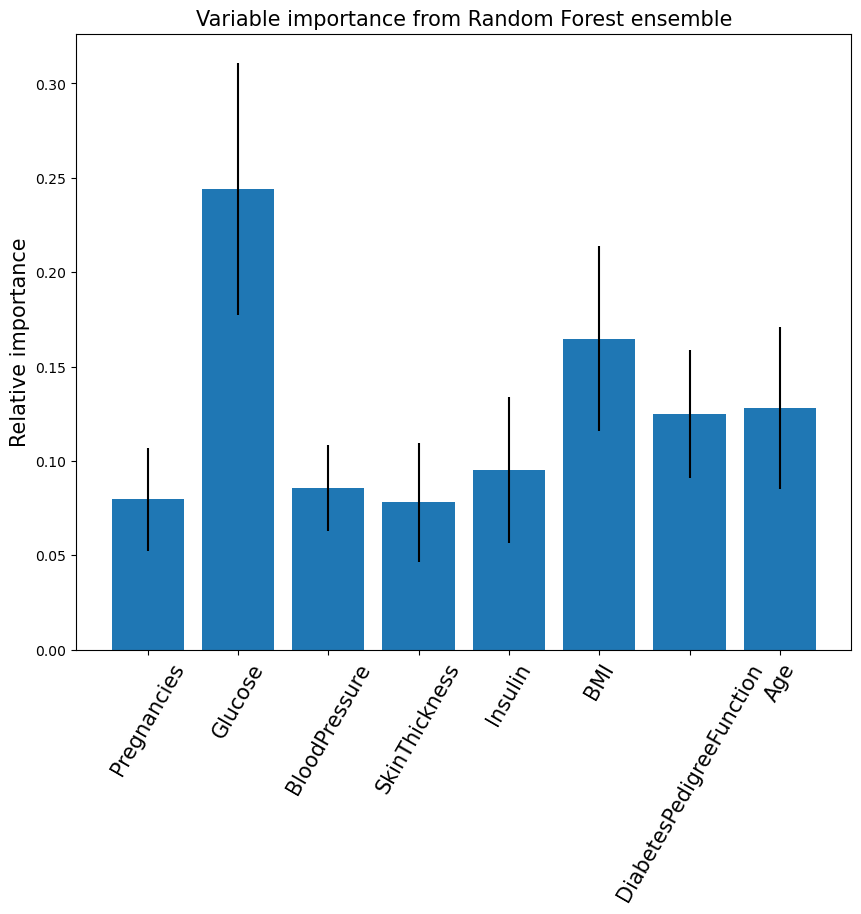

In [52]:
fig = plt.figure(figsize=(10,8))
plt.bar(X.columns,rf_importances, yerr=rf_std)
plt.xticks(rotation=60,fontsize=15)
plt.xlabel("",fontsize=15)
plt.ylabel("Relative importance",fontsize=15)
plt.title("Variable importance from Random Forest ensemble",fontsize=15)
plt.savefig("Variable importance from Random Forest ensemble.png")
plt.show()

In [54]:
# metrics table with all variables: Accuracy (%) Precision (%) Sensitivity (%) Specificity (%) F-score (%) AUC (%)

# Calculate classification metrics for each model
dt_metrics = classification_metrics(dt.predict_proba(X_test)[:, 1], y_test)
rf_metrics = classification_metrics(rf.predict_proba(X_test)[:, 1], y_test)
ab_metrics = classification_metrics(ab.predict_proba(X_test)[:, 1], y_test)

# Add XGBoost to the metrics calculation
xg_metrics = classification_metrics(xg_clf.predict_proba(X_test)[:, 1], y_test)


In [55]:
# Create an empty DataFrame with the specified columns
metrics_table = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F-Score', 'AUC'])

# Add metrics for each classifier
metrics_table.loc['Decision Tree'] = dt_metrics
metrics_table.loc['Random Forest'] = rf_metrics
metrics_table.loc['AdaBoost'] = ab_metrics

# Add XGBoost metrics
metrics_table.loc['XGBoost'] = xg_metrics

# Display the metrics table
metrics_table

,Accuracy,Precision,Recall,Specificity,F-Score,AUC
Decision Tree,0.818182,0.676923,0.862745,0.796117,0.758621,0.864839
Random Forest,0.915584,0.880000,0.862745,0.941748,0.871287,0.972111
AdaBoost,0.876623,0.796296,0.843137,0.893204,0.819048,0.922901
XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Logistic Regression

In [69]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_grad(z):
    return sigmoid(z)*(1-sigmoid(z))

def ReLU(x):
    return np.multiply((x >= 0), x)

def ReLU_grad(x):
    return (x >= 0)*1

def leakyReLU(x):
    return np.multiply((x >= 0), x) + np.multiply((x < 0), x * 0.1)

def leakyReLU_grad(x):
    return (x >= 0)*1 + (x < 0)*0.1

def linear(x):
    return x

def linear_grad(x):
    return np.ones(np.shape(x))

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1 - np.tanh(x)*np.tanh(x)


# Cost function gradients used in the training of the neural network

# regression
def regr_cost_grad(y_data, y_tilde):
    return (2 / y_tilde.shape[0]) * (y_tilde - y_data)

# classification
def class_cost_grad(y_data, y_tilde):
        return (y_tilde - y_data) / y_tilde.shape[0]


# Importing packages

import numpy as np
from activation_functions import *



def gradient_descent(X, y, eta, n_its):

    """ function that does gradient descent with fixed learning rate """

    # initialize betas randomly
    beta = np.random.randn(np.shape(X)[1],1)

    for iter in range(n_its):
        gradient = X.T @ (X @ beta-y)
        beta -= eta*gradient

    return beta


def gradient_descent_linreg(X, y, n_its):

    """ function that does gradient descent for OLS """

    # initialize betas randomly
    beta = np.random.randn(np.shape(X)[1],1)

    # compute the hessian
    H = X.T @ X
    EigValues, EigVectors = np.linalg.eig(H)
    eta = 1/np.max(EigValues)

    for iter in range(n_its):
        gradient = X.T @ (X @ beta-y)
        beta -= eta*gradient

    return beta



def gradient_descent_ridge(X, y, eta, lam, n_its):

    """ function that does gradient descent for ridge """

    # initialize betas randomly
    beta = np.random.randn(X.shape[1],1)

    # compute the hessian
    H = (X.T @ X) + 2 * lam * np.eye(X.shape[1])
    EigValues, EigVectors = np.linalg.eig(H)
    eta = 1/np.max(EigValues)

    for iter in range(n_its):
        gradient = X.T @ (X @ (beta)-y)+2*lam*beta
        beta -= eta*gradient

    return beta


def gradient_descent_with_momentum(X, y, eta, delta, n_its):

    """ function that does gradient descent with momentum """

    # initialize betas randomly
    beta = np.random.randn(X.shape[1],1)
    change=0

    for iter in range(n_its):
        gradient = X.T @ (X @ (beta)-y)
        new_change = eta*gradient + delta*change
        beta -= new_change
        change = new_change

    return beta


def stochastic_gradient_descent(X, y, eta, n_epochs, size_minibatch):

    """ function that does stochastic gradient descent """

    # initialize betas randomly
    beta = np.random.randn(X.shape[1],1)
    m = int(X.shape[0]/size_minibatch)

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = size_minibatch * np.random.randint(m)
            xi = X[random_index:random_index + size_minibatch]
            yi = y[random_index:random_index + size_minibatch]
            gradients = xi.T @ ((xi @ beta)-yi)
            beta -= eta*gradients

    return beta



def stochastic_gradient_descent_with_adagrad(X, y, eta, delta, n_epochs, size_minibatch):

    """ SGD using Adagrad """

    # initialize betas randomly
    beta = np.random.randn(X.shape[1],1)
    m = int(X.shape[0]/size_minibatch)

    for epoch in range(n_epochs):
        Giter = np.zeros(shape=(X.shape[1],X.shape[1]))
        for i in range(m):
            random_index = size_minibatch * np.random.randint(m)
            xi = X[random_index:random_index + size_minibatch]
            yi = y[random_index:random_index + size_minibatch]
            gradients = xi.T @ ((xi @ beta)-yi)
            Giter += gradients @ gradients.T
            Ginverse = np.c_[eta/(delta+np.sqrt(np.diagonal(Giter)))]
            beta -= np.multiply(Ginverse,gradients)

    return beta





def stochastic_gradient_descent_with_rmsprop(X, y, eta, delta, rho, n_epochs, size_minibatch):

    """ SGD using RMSProp """

    # initialize betas randomly
    beta = np.random.randn(X.shape[1],1)
    m = int(X.shape[0]/size_minibatch)

    for epoch in range(n_epochs):
        Giter = np.zeros(shape=(X.shape[1],X.shape[1]))
        for i in range(m):
            random_index = size_minibatch * np.random.randint(m)
            xi = X[random_index:random_index + size_minibatch]
            yi = y[random_index:random_index + size_minibatch]
            gradients = xi.T @ ((xi @ beta)-yi)
            Previous = Giter
            Giter += gradients @ gradients.T
            Gnew = (rho*Previous+(1-rho)*Giter)
            Ginverse = np.c_[eta/(delta+np.sqrt(np.diagonal(Gnew)))]
            beta -= np.multiply(Ginverse,gradients)

    return beta





def stochastic_gradient_descent_with_adam(X, y, eta, delta, rho1, rho2, n_epochs, size_minibatch):

    """ SGD using ADAM """

    # initialize betas randomly
    beta = np.random.randn(X.shape[1],1)
    m = int(X.shape[0]/size_minibatch)

    for epoch in range(n_epochs):
        Giter = np.zeros(shape=(X.shape[1],X.shape[1]))
        previous = np.zeros(shape=(X.shape[1],1))
        for i in range(m):
            random_index = size_minibatch * np.random.randint(m)
            xi = X[random_index:random_index + size_minibatch]
            yi = y[random_index:random_index + size_minibatch]
            gradients = xi.T @ ((xi @ beta)-yi)
            gnew = (rho1*previous+(1-rho1)*gradients)
            previous = gnew
            Previous = Giter
            Giter += gradients @ gradients.T
            Gnew = (rho2*Previous+(1-rho2)*Giter)
            Ginverse = np.c_[eta/(delta+np.sqrt(np.diagonal(Gnew)))]
            beta -= np.multiply(Ginverse,gnew)

    return beta



def logistic_regression_sgd(X, y, eta, regularization, n_epochs, size_minibatch):
    """ function that does logistic regression with minibatch stochastic gradient descent """

    # Convert y to a numpy array and reshape
    y = y.to_numpy().reshape((len(y),))  # .to_numpy() to handle pandas Series

    # initialize betas randomly
    beta = np.random.randn(X.shape[1],)
    m = int(X.shape[0] / size_minibatch)

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = size_minibatch * np.random.randint(m)
            xi = X[random_index:random_index + size_minibatch]
            yi = y[random_index:random_index + size_minibatch]
            gradients = (np.squeeze(sigmoid(xi @ beta)) - yi) @ xi + regularization * beta
            beta -= eta * gradients

    return beta


In [70]:
# grid search best parameters logistic regression

# tuning learning rate and regularization parameter

y_train_log = y_train
y_test_log = y_test

eta_list = [0.001, 0.01, 0.02, 0.05, 0.07, 0.09]
reg_list = [0, 0.01, 0.1, 1, 10]
accuracy_mat = np.zeros((len(reg_list),len(eta_list)))

for j in range(len(eta_list)):
    for i in range(len(reg_list)):
       
        reg = reg_list[i]
        eta = eta_list[j]

        betas = logistic_regression_sgd(X_train, y_train_log, eta, reg, 200, 50)
        ypred = (sigmoid(X_test @ betas)>=0.5)
        accuracy_mat[i][j] = sum(y_test_log == ypred)/np.shape(y_test)[0]

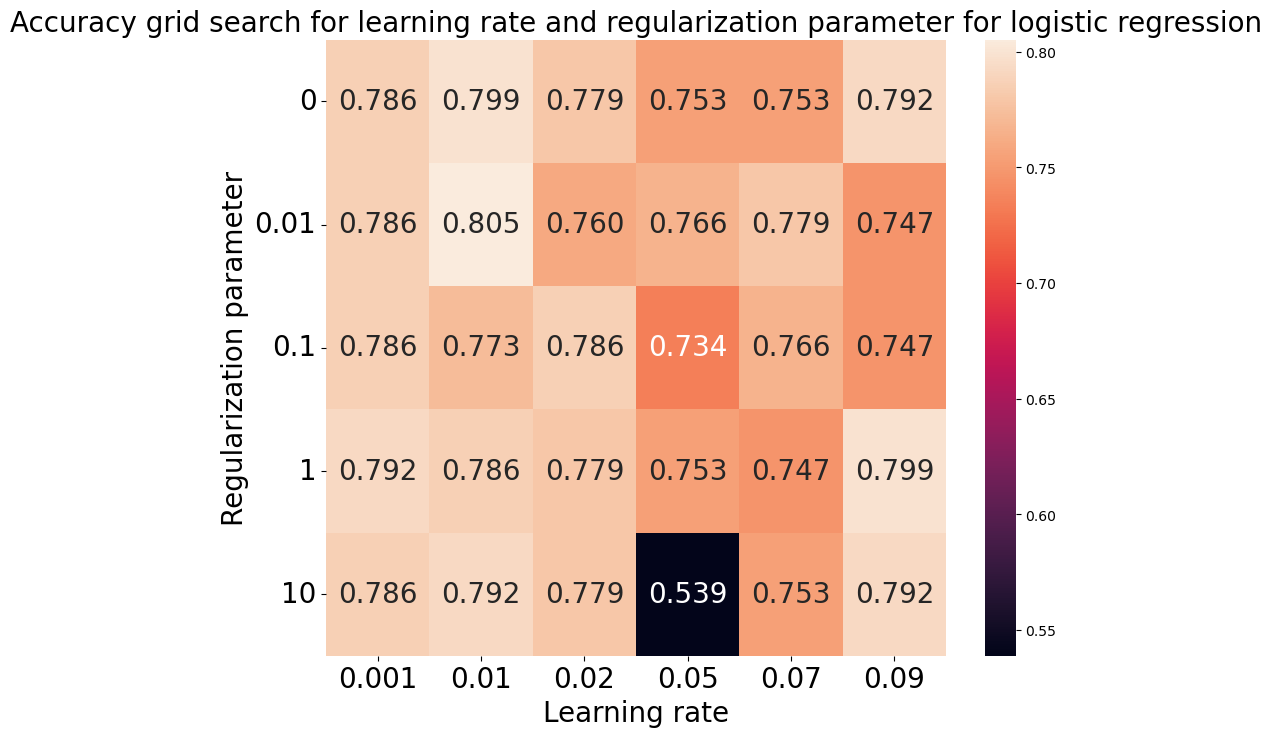

In [72]:
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(accuracy_mat, xticklabels=eta_list, yticklabels=reg_list, annot=True, annot_kws={"size": 20}, fmt=".3f")
plt.ylabel("Regularization parameter", fontsize=20)
plt.xlabel("Learning rate", fontsize=20)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize=20,rotation=0)
plt.title("Accuracy grid search for learning rate and regularization parameter for logistic regression", fontsize=20)
plt.savefig("logreg_accuracy_lr_nn_grid_search.png")

### Neural Network

In [76]:
# tuning learning rate and regularization parameter

y_train_nn = y_train.to_numpy().reshape(len(y_train), 1)
y_test_nn = y_test.reshape(len(y_test), 1)


eta_list = [0.001, 0.01, 0.02, 0.05, 0.075]
reg_list = [0, 0.01, 0.1, 1, 10]
accuracy_mat_nn = np.zeros((len(reg_list),len(eta_list)))

for j in range(len(eta_list)):
    for i in range(len(reg_list)):
       
        reg = reg_list[i]
        eta = eta_list[j]

        nn = NeuralNetwork(8, class_cost_grad,random_state=1)
        layer1 = Layer(30, sigmoid, sigmoid_grad)
        layer2 = Layer(1, sigmoid, sigmoid_grad)
        nn.add_layer(layer1)
        nn.add_layer(layer2)
        nn.train(X_train,y_train_nn,eta=eta,regularization=reg, epochs=100)

        pred = nn.feed_forward_out(X_test)
        pred = pred.round()
        accuracy_mat_nn[i][j] = np.sum(pred == y_test_nn)/y_test.shape[0]

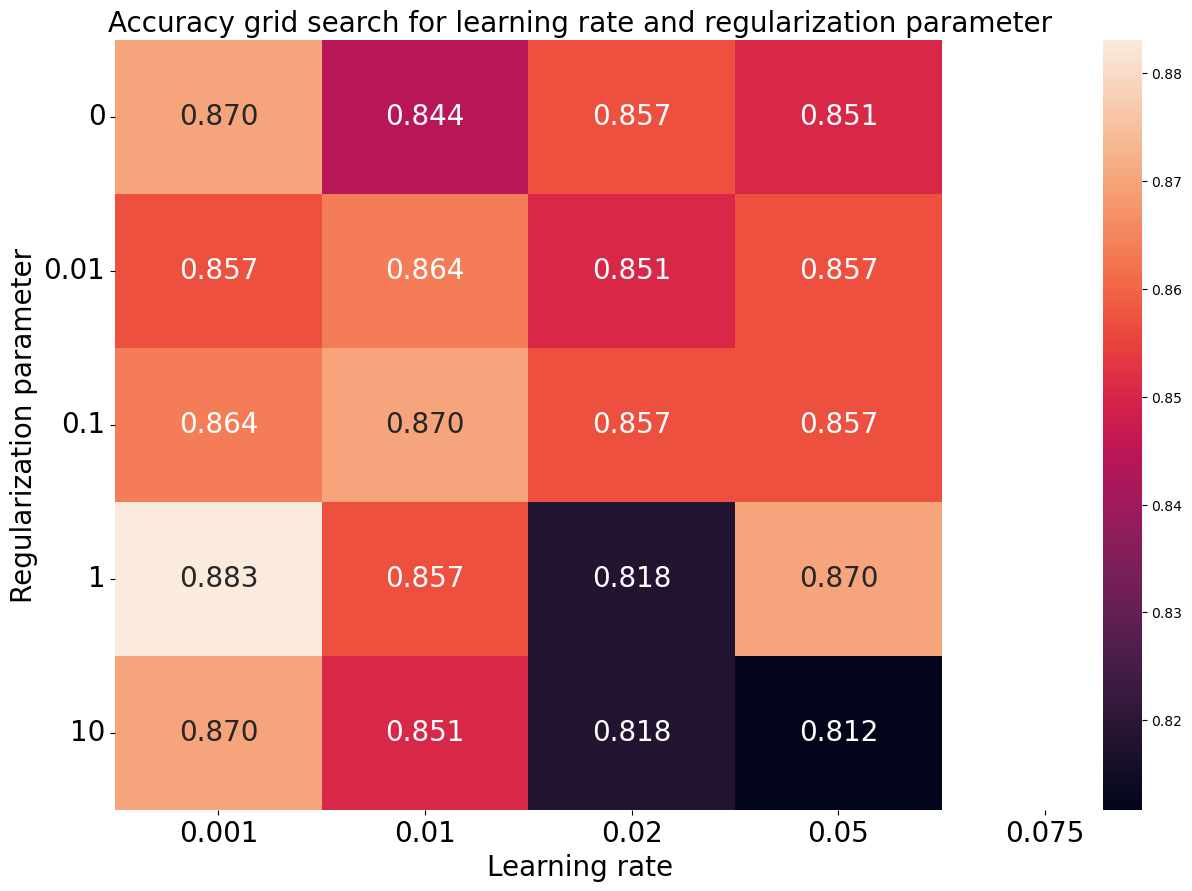

In [80]:
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(accuracy_mat_nn, xticklabels=eta_list, yticklabels=reg_list, annot=True, annot_kws={"size": 20}, fmt=".3f")
plt.ylabel("Regularization parameter", fontsize=20)
plt.xlabel("Learning rate", fontsize=20)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize=20,rotation=0)
plt.title("Accuracy grid search for learning rate and regularization parameter", fontsize=20)
plt.savefig("accuracy_grid_search.png")

In [78]:
# tuning learning rate and number of neurons

eta_list = [0.001, 0.01, 0.02, 0.05, 0.075]
n_neurons_list = [10, 20, 30, 50]
accuracy_mat_nn = np.zeros((len(eta_list),len(n_neurons_list)))

for j in range(len(eta_list)):
    for i in range(len(n_neurons_list)):
       
        n_neurons = n_neurons_list[i]
        eta = eta_list[j]

        nn = NeuralNetwork(8,class_cost_grad,random_state=1)
        layer1 = Layer(n_neurons, sigmoid, sigmoid_grad)
        layer2 = Layer(1, sigmoid, sigmoid_grad)
        nn.add_layer(layer1)
        nn.add_layer(layer2)
        nn.train(X_train,y_train_nn,eta=eta, epochs=200)

        pred = nn.feed_forward_out(X_test)
        pred = pred.round()
        accuracy_mat_nn[j][i] = np.sum(pred == y_test_nn)/y_test.shape[0]

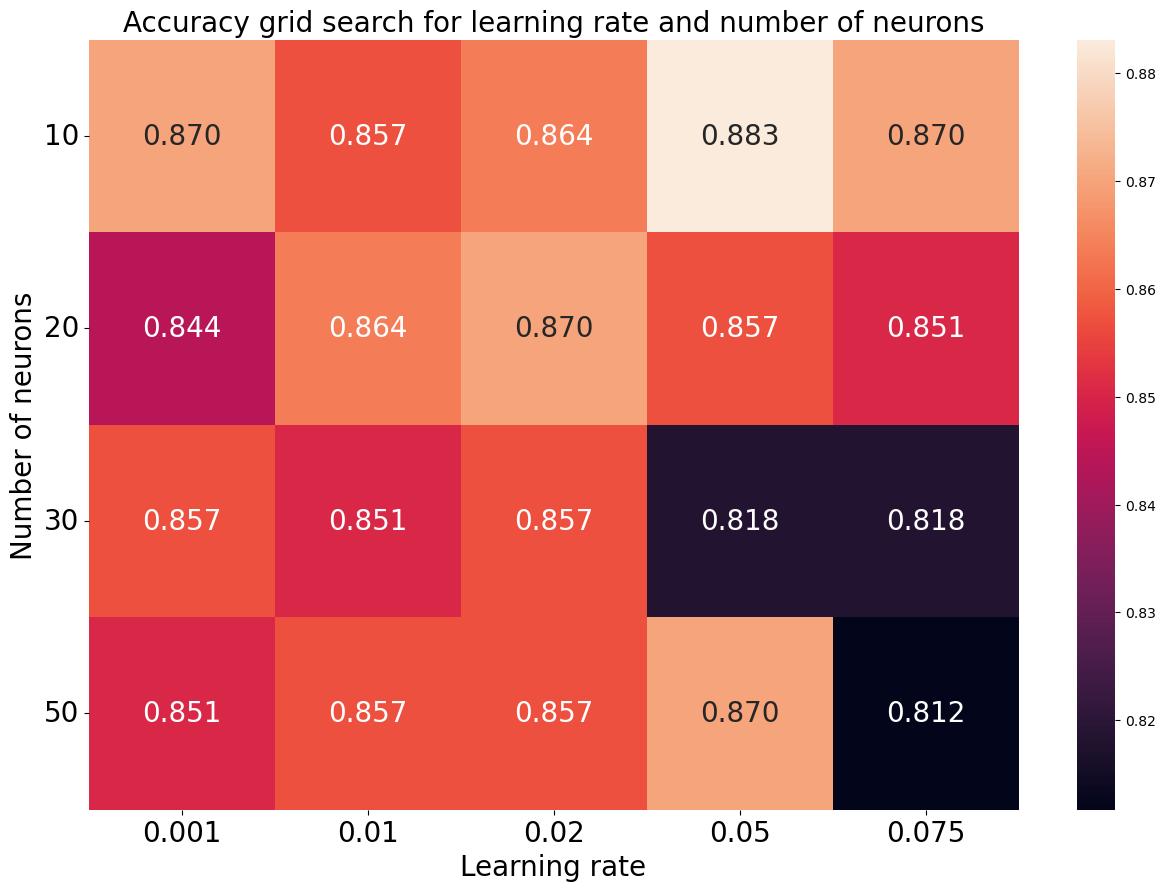

In [79]:
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(accuracy_mat_nn.T, xticklabels=eta_list, yticklabels=n_neurons_list, annot=True, annot_kws={"size": 20}, fmt=".3f")
plt.ylabel("Number of neurons", fontsize=20)
plt.xlabel("Learning rate", fontsize=20)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize=20)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize=20,rotation=0)
plt.title("Accuracy grid search for learning rate and number of neurons", fontsize=20)
plt.savefig("accuracy_lr_nn_grid_search.png")

In [81]:
# different number of hidden layers

n_epochs = 100
eta = 0.05
step = 5

nn_1 = NeuralNetwork(8,class_cost_grad,random_state=1)
nn_2 = NeuralNetwork(8,class_cost_grad,random_state=1)
nn_3 = NeuralNetwork(8,class_cost_grad,random_state=1)
layer11 = Layer(20,sigmoid,sigmoid_grad)
layer21 = Layer(1,sigmoid,sigmoid_grad)
layer12 = Layer(20,sigmoid,sigmoid_grad)
layer22 = Layer(20,sigmoid,sigmoid_grad)
layer32 = Layer(1,sigmoid,sigmoid_grad)
layer13 = Layer(20,sigmoid,sigmoid_grad)
layer23 = Layer(20,sigmoid,sigmoid_grad)
layer33 = Layer(20,sigmoid,sigmoid_grad)
layer43 = Layer(1,sigmoid,sigmoid_grad)

nn_1.add_layer(layer11)
nn_1.add_layer(layer21)
nn_2.add_layer(layer12)
nn_2.add_layer(layer22)
nn_2.add_layer(layer32)
nn_3.add_layer(layer13)
nn_3.add_layer(layer23)
nn_3.add_layer(layer33)
nn_3.add_layer(layer43)

acc_1 = []
acc_2 = []
acc_3 = []


for i in range(0,n_epochs,step):
    
    acc_1.append(np.sum(nn_1.feed_forward_out(X_test).round() == y_test_nn)/y_test_nn.shape[0])
    acc_2.append(np.sum(nn_2.feed_forward_out(X_test).round() == y_test_nn)/y_test_nn.shape[0])
    acc_3.append(np.sum(nn_3.feed_forward_out(X_test).round() == y_test_nn)/y_test_nn.shape[0])
    nn_1.train(X_train,y_train_nn,eta=eta,epochs=step, minibatch_size = 20)
    nn_2.train(X_train,y_train_nn,eta=eta,epochs=step, minibatch_size = 20)
    nn_3.train(X_train,y_train_nn,eta=eta,epochs=step, minibatch_size = 20)

C:\Users\user\Desktop\FYS4155\project_3\example\one\activation_functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


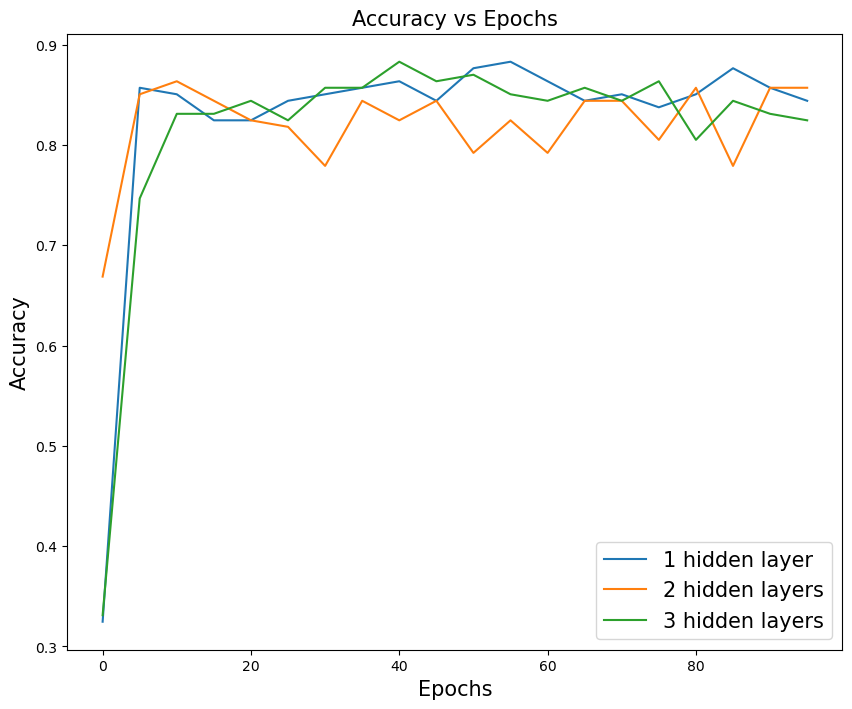

In [82]:
plt.figure(figsize=(10,8))
plt.plot(range(0,n_epochs,step),acc_1,label='1 hidden layer')
plt.plot(range(0,n_epochs,step),acc_2,label='2 hidden layers')
plt.plot(range(0,n_epochs,step),acc_3,label='3 hidden layers')
plt.legend(fontsize=15)
plt.title("Accuracy vs Epochs", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.savefig("class_number_of_hidden_layers.png")

In [83]:
# different activation functions

n_epochs = 200
step = 5
eta = 0.05

nn_sigm = NeuralNetwork(8, class_cost_grad,random_state=1)
nn_relu = NeuralNetwork(8, class_cost_grad,random_state=1)
nn_lrelu = NeuralNetwork(8, class_cost_grad,random_state=1)
nn_tanh = NeuralNetwork(8, class_cost_grad,random_state=1)
layer1sigm = Layer(20,sigmoid,sigmoid_grad)
layer2sigm= Layer(1,sigmoid,sigmoid_grad)
layer1relu = Layer(20,ReLU,ReLU_grad)
layer2relu = Layer(1,sigmoid,sigmoid_grad)
layer1lrelu = Layer(20,leakyReLU,leakyReLU_grad)
layer2lrelu = Layer(1,sigmoid,sigmoid_grad)
layer1tanh = Layer(20,tanh,tanh_grad)
layer2tanh = Layer(1,sigmoid,sigmoid_grad)
nn_sigm.add_layer(layer1sigm)
nn_sigm.add_layer(layer2sigm)
nn_relu.add_layer(layer1relu)
nn_relu.add_layer(layer2relu)
nn_lrelu.add_layer(layer1lrelu)
nn_lrelu.add_layer(layer2lrelu)
nn_tanh.add_layer(layer1tanh)
nn_tanh.add_layer(layer2tanh)

acc_sigm = []
acc_relu = []
acc_lrelu = []
acc_tanh = []

for i in range(0,n_epochs,step):
    acc_sigm.append(np.sum(nn_sigm.feed_forward_out(X_test).round() == y_test_nn)/y_test.shape[0])
    acc_relu.append(np.sum(nn_relu.feed_forward_out(X_test).round() == y_test_nn)/y_test.shape[0])
    acc_lrelu.append(np.sum(nn_lrelu.feed_forward_out(X_test).round() == y_test_nn)/y_test.shape[0])
    acc_tanh.append(np.sum(nn_tanh.feed_forward_out(X_test).round() == y_test_nn)/y_test.shape[0])
    nn_sigm.train(X_train,y_train_nn,eta=eta,epochs=step)
    nn_relu.train(X_train,y_train_nn,eta=eta,epochs=step)
    nn_lrelu.train(X_train,y_train_nn,eta=eta,epochs=step)
    nn_tanh.train(X_train,y_train_nn,eta=eta,epochs=step)

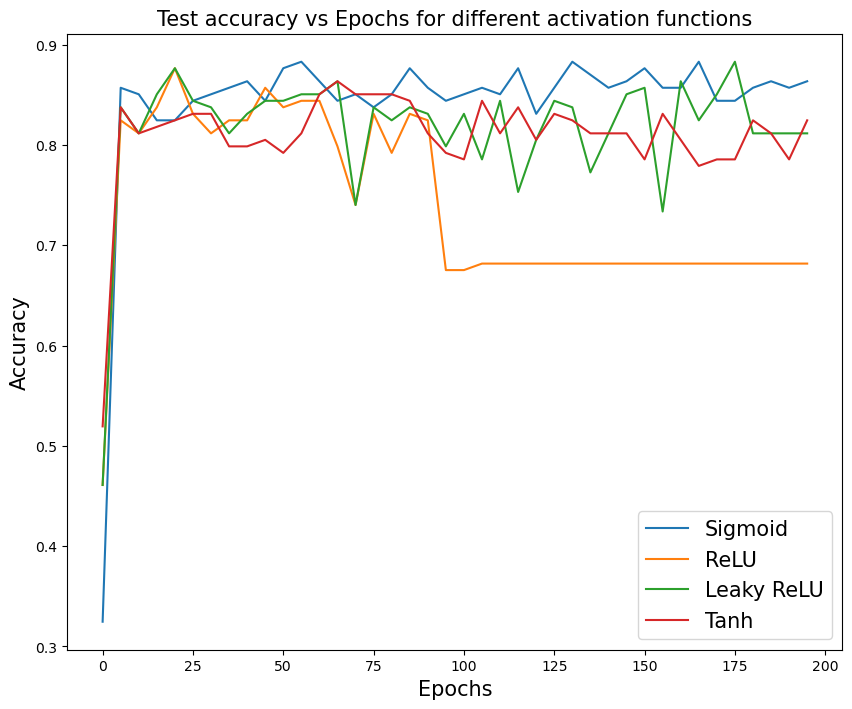

In [84]:
plt.figure(figsize=(10,8))
plt.plot(range(0,n_epochs,step),acc_sigm,label='Sigmoid')
plt.plot(range(0,n_epochs,step),acc_relu,label='ReLU')
plt.plot(range(0,n_epochs,step),acc_lrelu,label='Leaky ReLU')
plt.plot(range(0,n_epochs,step),acc_tanh,label='Tanh')
plt.legend(fontsize=15)
plt.title("Test accuracy vs Epochs for different activation functions", fontsize=15)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.savefig("class_nn_activation_functions.png")

In [85]:
# roc curves

betas = logistic_regression_sgd(X_train, y_train_log, 0.001, 1, 200, 50)
lr_probs = sigmoid(X_test @ betas)
lr_fpr, lr_tpr, _ = skm.roc_curve(y_test, lr_probs)
lr_roc_auc = skm.roc_auc_score(y_test, lr_probs)

nn = NeuralNetwork(8, class_cost_grad, random_state=1)
layer1 = Layer(20, sigmoid, sigmoid_grad)
layer2 = Layer(20, sigmoid, sigmoid_grad)
layer3 = Layer(1, sigmoid, sigmoid_grad)
nn.add_layer(layer1)
nn.add_layer(layer2)
nn.add_layer(layer3)
nn.train(X_train, y_train_nn, eta=0.05, epochs=200)
nn_probs = nn.feed_forward_out(X_test)
nn_fpr, nn_tpr, _ = skm.roc_curve(y_test, nn_probs)
nn_roc_auc = skm.roc_auc_score(y_test, nn_probs)

C:\Users\user\Desktop\FYS4155\project_3\example\one\activation_functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


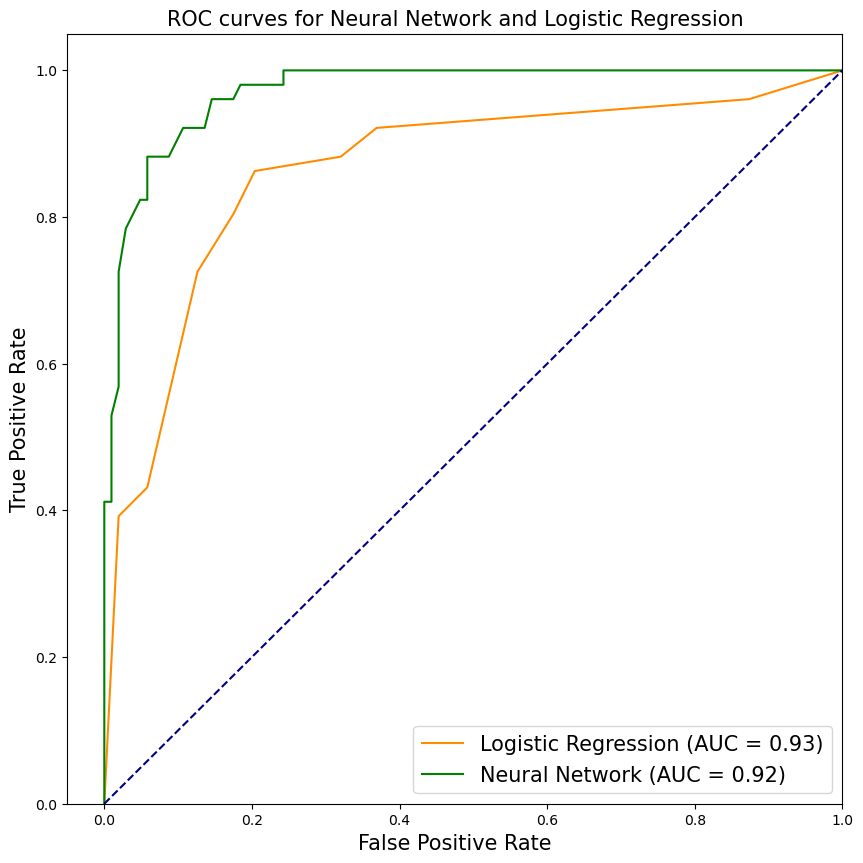

In [86]:
plt.figure(figsize=(10,10))
plt.plot(dt_fpr,dt_tpr,color="darkorange",label="Logistic Regression (AUC = %0.2f)" % lr_roc_auc)
plt.plot(rf_fpr,rf_tpr,color="green",label="Neural Network (AUC = %0.2f)" % nn_roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate",fontsize=15)
plt.ylabel("True Positive Rate",fontsize=15)
plt.title("ROC curves for Neural Network and Logistic Regression",fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.savefig("ROC curves for Neural Network and Logistic Regression.png")
plt.show()

In [87]:
lr_metrics = classification_metrics(lr_probs,y_test)
nn_metrics = classification_metrics(nn_probs,y_test)

### Final comparison

In [88]:
metrics_table = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F-Score', 'AUC'])
metrics_table.loc['Decision Tree'] = dt_metrics
metrics_table.loc['Random Forest'] = rf_metrics
metrics_table.loc['AdaBoost'] = ab_metrics
metrics_table.loc['XGBoost'] = xg_metrics
metrics_table.loc['Logistic Regression'] = lr_metrics
metrics_table.loc['Neural Network'] = nn_metrics
metrics_table

,Accuracy,Precision,Recall,Specificity,F-Score,AUC
Decision Tree,0.818182,0.676923,0.862745,0.796117,0.758621,0.864839
Random Forest,0.915584,0.880000,0.862745,0.941748,0.871287,0.972111
AdaBoost,0.876623,0.796296,0.843137,0.893204,0.819048,0.922901
XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Logistic Regression,0.792208,0.630137,0.901961,0.737864,0.741935,0.929754
Neural Network,0.857143,0.822222,0.725490,0.922330,0.770833,0.922711
